In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [156]:
import pickle
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import utils

In [158]:
with open("./output_data/camera_calibration.p", 'rb') as f:
    calibration = pickle.load(f)

mtx, dist = calibration["mtx"], calibration["dist"]

with open("./output_data/warp_matrix.p", 'rb') as f:
    warp_matrix = pickle.load(f)

M, M_inv = warp_matrix["M"], warp_matrix["M_inv"]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def combined_binary(img):
    channel_thresh = (80, 255)
    thresh = (25, 255)
    ksize = 13
    ch_binary = utils.color_channel_thresh(img, thresh=channel_thresh, color_space='hls_s')
    binary = utils.abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh, color_space='rgb_r')

    cl_binary = np.dstack(( np.zeros_like(binary), binary, ch_binary)) * 255
    cb_binary = np.zeros_like(ch_binary)
    cb_binary[(ch_binary == 1) | (binary == 1)] = 1
    
    return ch_binary, cl_binary


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None


left_line = Line()
right_line = Line()
fitting_info = {"ok": False}
debug_dict = {}
curve_hist = []

def process_image(image):
    """
    This method apply some preprocessing technique to the given image
    
    - Undistort image by using camera calibartion result
    - Binarize RGB color image
    - Apply perspective transformation
    - Fit lane area by using  quadratic function
    - Apply inverse transformation
    """
    
    # undistort image
    img_undistort = cv2.undistort(image, mtx, dist, None, mtx)

    # binarize image
    img_binary, _ = combined_binary(img_undistort)
    # perspective transformation
    img_warp_bin = utils.warp_img(img_binary, M)
    img_warp_color = utils.warp_img(img_undistort, M)
    
    #  fit lane
    if(not fitting_info["ok"]):
        try:
            fit_result = utils.fit_lane(img_warp_bin)
            fit_result = utils.update_fit_lane(img_warp_bin, fit_result)        
        except utils.EmptyDataError:            
            return image
    else:
        try:
            fit_result = fitting_info["fit_result"]
            fit_result = utils.update_fit_lane(img_warp_bin, fit_result)
        except utils.EmptyDataError:
            fitting_info["ok"] = False


    fitting_info["fit_result"] = fit_result
    left_line.best_fit = fit_result["left_fit"]
    right_line.best_fit = fit_result["right_fit"]
    fit_region_img = fit_result["fit_region_img"]
    
    fit_region_img = utils.warp_img(fit_region_img, M_inv)
    
    result = utils.weighted_img(fit_region_img, image, alpha=1, beta=0.3)
    
    w, h = (128*3, 72*3)
    result[:h, :w] = cv2.resize(img_warp_color, (w, h))
    result[:h, w:2*w] = cv2.cvtColor(255*cv2.resize(img_warp_bin, (w, h)),cv2.COLOR_GRAY2RGB)

    y_eval = np.max(fit_result["ploty"])    
    left_curverad, right_curverad = utils.measure_curvature(y_eval, fit_result, xm_per_pix, ym_per_pix)
    curve_text = "curve_left: {0:.2f}m\ncurve_right: {1:.2f}m ".format(left_curverad, right_curverad)
    cv2.putText(result, curve_text, (0, h+50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
    
    curve_hist.append({"left_curve": left_curverad, "right_curve": right_curverad})
    
    return result

In [159]:
white_output = 'output_video/project_solution.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
clip = clip.set_fps(4)
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/project_solution.mp4
[MoviePy] Writing video output_video/project_solution.mp4



100%|██████████| 202/202 [00:42<00:00,  3.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_solution.mp4 

CPU times: user 31.1 s, sys: 4.98 s, total: 36.1 s
Wall time: 44.7 s


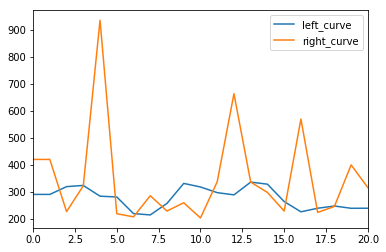

In [145]:
import pandas as pd
df_curve = pd.DataFrame(curve_hist)

df_curve.plot()


In [25]:
white_output = 'output_video/challenge_solution.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("challenge_video.mp4")
clip = clip.set_fps(5)
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/challenge_solution.mp4
[MoviePy] Writing video output_video/challenge_solution.mp4



100%|██████████| 81/81 [00:11<00:00,  7.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_solution.mp4 

CPU times: user 9.43 s, sys: 1.58 s, total: 11 s
Wall time: 13.3 s
